In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.append("/Users/mxhf/work/MPE/hetdex/src/vdrp_rewrite/vdrp/src/python/")

In [2]:
import vdrp

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from astropy.table import Table

In [5]:
import os

In [6]:
from astropy.io import ascii
import numpy as np

In [29]:
basedir = "20180611v017.vdrp"

shout_ifu_file = "shout.ifustars"
exposures = ["exp01", "exp02", "exp03"]

xy_files = {exp: "xy_{}.dat".format(exp) for exp in exposures}
tmp_csv_files = {exp: "tmp_{}.csv".format(exp) for exp in exposures}


radec_files = {exp: "radec2_{}.dat".format(exp) for exp in exposures}

fplane_file = "fplane.txt"


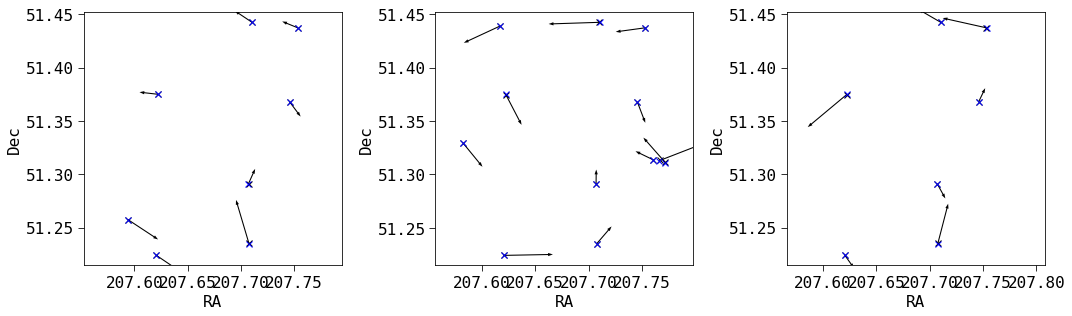

In [12]:
def mk_dist_plot(ax, xy, exaggeration = 100.):
    
    ax.plot(xy["RA_det"], xy["DEC_det"],'x')
    ax.plot(xy["RA_cat"], xy["DEC_cat"],'x')

    
    for i in range(len(xy)):
        ax.arrow(xy["RA_cat"][i], xy["DEC_cat"][i], \
                  (xy["RA_det"][i]-xy["RA_cat"][i])*exaggeration, (xy["DEC_det"][i]-xy["DEC_cat"][i])*exaggeration)
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    ax.axis("equal")
    
f = plt.figure(figsize=[15,4.5])



for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    ax = plt.subplot(1,3,i+1)
    mk_dist_plot(ax, xy)
f.tight_layout()

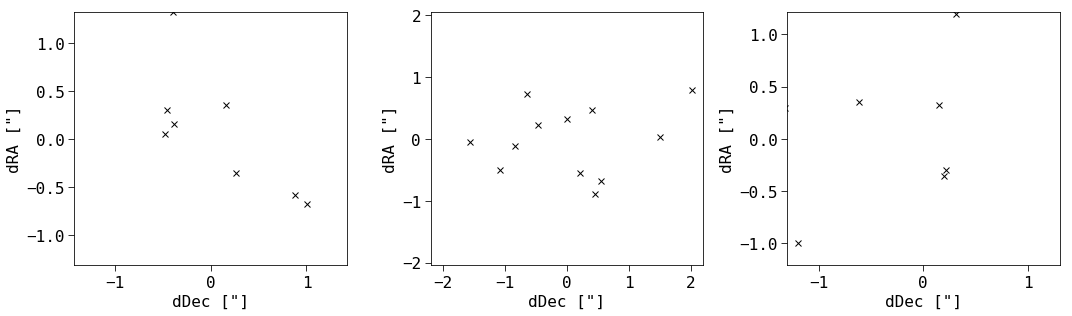

In [14]:
def mk_res_plot(ax, xy):
    ax.plot((xy["RA_det"]-xy["RA_cat"])*3600., (xy["DEC_det"]-xy["DEC_cat"])*3600.,'x')
    ax.set_ylabel("dRA [\"]")
    ax.set_xlabel("dDec [\"]")
    ax.axis("equal")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    mx = np.max(xlim + ylim)
    ax.set_xlim([-mx,mx])
    ax.set_ylim([-mx,mx])
    
f = plt.figure(figsize=[15,4.5])
for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    ax = plt.subplot(1,3,i+1)
    mk_res_plot(ax, xy)
f.tight_layout()

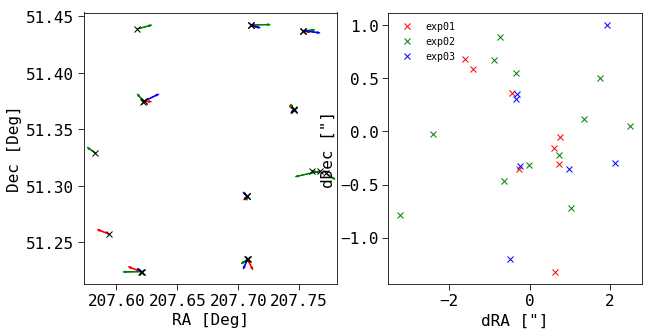

In [57]:
# plots distortion and residuels but for all exposures in one plot

f = plt.figure(figsize=[10,5])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)


def mk_dist_all_plot(ax, basedir, xy_files):
    exposures = ["exp01", "exp02", "exp03"]

    exaggeration = 20.
    colors = ['r','g','b']
    for i, exp in enumerate( exposures ):

        xy = ascii.read(os.path.join(basedir,xy_files[exp]))

        ra1,dec1 = xy['RA_det'], xy['DEC_det']
        ra2,dec2 = xy['RA_cat'], xy['DEC_cat']

        dra = (ra2-ra1)/np.cos(np.deg2rad(dec1) )
        ddec = dec2-dec1

        ax.plot(ra1,dec1,'kx')
        for x,y,dx,dy in zip(ra1, dec1, dra, ddec):
            ax.arrow(x,y,dx*exaggeration,dy*exaggeration, width=.0005, color=colors[i])

    ax.set_xlabel("RA [Deg]")
    ax.set_ylabel("Dec [Deg]")


    
def mk_res_all_plot(ax, basedir, xy_files):
    exposures = ["exp01", "exp02", "exp03"]
    exaggeration = 20.
    colors = ['r','g','b']
    for i, exp in enumerate( exposures ):
        xy = ascii.read(os.path.join(basedir,xy_files[exp]))
        ra1,dec1 = xy['RA_det'], xy['DEC_det']
        ra2,dec2 = xy['RA_cat'], xy['DEC_cat']
        dra = (ra2-ra1)/np.cos(np.deg2rad(dec1) )
        ddec = dec2-dec1
        ax.plot(dra*3600.,ddec*3600.,'x', color=colors[i], label=exp)

    ax.set_xlabel("dRA [\"]")
    ax.set_ylabel("dDec [\"]")
    l = ax.legend()
    l.draw_frame(False)
    
    
mk_dist_all_plot(ax1, basedir, xy_files)
mk_res_all_plot(ax2, basedir, xy_files) 

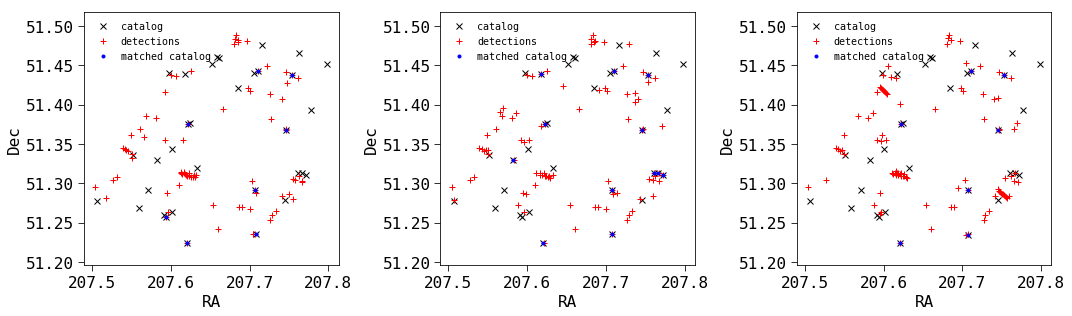

In [19]:
def mk_match_plot(ax, shout_ifu, tmp_csv, xy):

    ax.plot( shout_ifu["col3"], shout_ifu["col4"], 'kx', label="catalog")
    ax.plot( tmp_csv["ra"], tmp_csv["dec"] , 'r+', label="detections")
    ax.plot(xy["RA_cat"], xy["DEC_cat"],'b.', label="matched catalog")
    l = ax.legend()
    l.draw_frame(False)
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    ax.axis("equal")

shout_ifu = Table.read(os.path.join(basedir, shout_ifu_file), format='ascii')

f = plt.figure(figsize=[15,4.5])
for i, exp in enumerate( exposures ):
    
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    tmp_csv = Table.read( os.path.join(basedir,tmp_csv_files[exp]) )
    
    
    ax = plt.subplot(1,3,i+1)
    mk_match_plot(ax, shout_ifu, tmp_csv, xy)
f.tight_layout()

In [22]:
from pyhetdex.het import fplane
import os

In [23]:
from pyhetdex.coordinates import astrometry
from pyhetdex.het.fplane import FPlane
from astropy.table import Table

In [24]:
import path
import glob
import numpy as np
from collections import OrderedDict
from astropy.io import fits
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
def get_exposures_files(basedir):
    """
    Create list of all file prefixes based
    on the existing collapsed IFU files in the current directory.
    
    From files:
    
    20180611T054545_015.fits
    ...
    20180611T054545_106.fits
    20180611T055249_015.fits
    ...
    20180611T055249_106.fits
    20180611T060006_015.fits
    ...
    20180611T060006_106.fits
    
    Creates:
    
    {
     'exp01' : ['20180611T054545_015',...,'20180611T054545_106']
     'exp02' : ['20180611T055249_015',...,'20180611T055249_106']
     'exp03' : ['20180611T060006_015',...,'20180611T060006_106']
    }


    Args:
       basedir (str): Directory to search.
    
    Returns:
       (OrderedDict): Ordered dictionary with pairs of exposure string "exp??" and time and list of 
    """
    ff = []
    with path.Path(basedir):
        ff = glob.glob('2???????T??????_???.fits')
    _exp_datetimes = [f[:19] for f in ff]
    
    exp_datetimes = np.sort( np.unique([p[:15] for p in _exp_datetimes]) )
    
    exposures_files = OrderedDict()
    for i,edt in enumerate(exp_datetimes):
        files_for_exposure = []
        for f in ff:
            if f.startswith(edt):
                files_for_exposure.append(f.replace('.fits',''))
        exposures_files["exp{:02d}".format(i+1)] = files_for_exposure
    return exposures_files

exposures_files = get_exposures_files(basedir)



In [26]:
def project_xy(basedir, radec_file, fplane_file, ra, dec):
    # Here we translate *all* catalog stars to x/y to display then and to 
    # see which ones got matched.
    # Call pyhetdex tangent_plane's functionality to project
    # ra,dec to x,y
    
    # read ra,dec, pa from radec2.dat
    ra0,dec0,pa0 = utils.read_radec( os.path.join(basedir, radec_file))
    # Carry out required changes to astrometry
    rot = 360.0 - (pa0 + 90.)
    # Set up astrometry from user supplied options
    tp = astrometry.TangentPlane(ra0, dec0, rot)
    # set up astrometry
    fp = FPlane( os.path.join(basedir, fplane_file) )
    # find positions
    ifu_xy = astrometry.ra_dec_to_xy(ra, dec, fp, tp)
    return ifu_xy

Loading image files
Loading image files
Loading image files


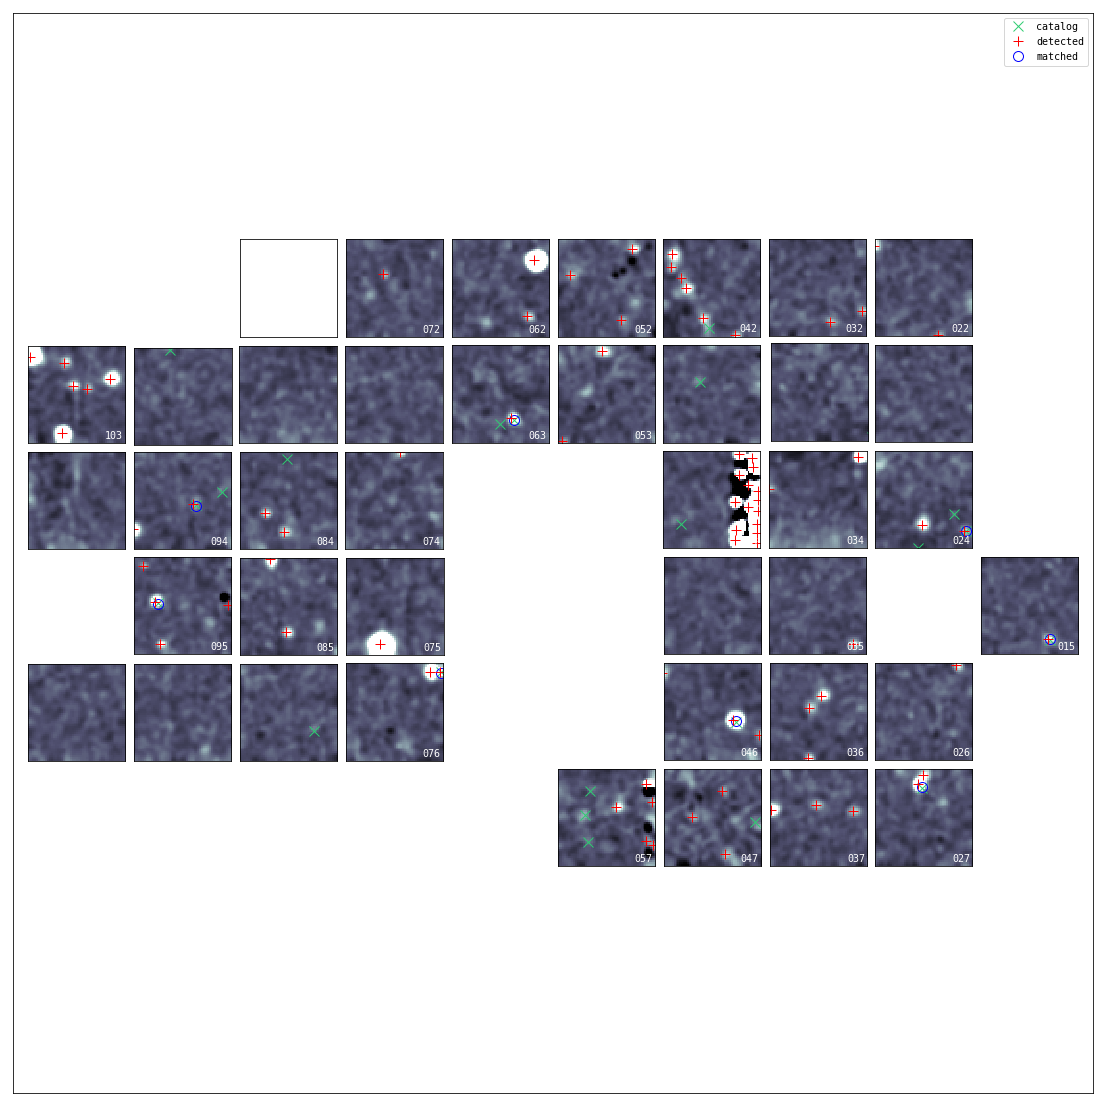

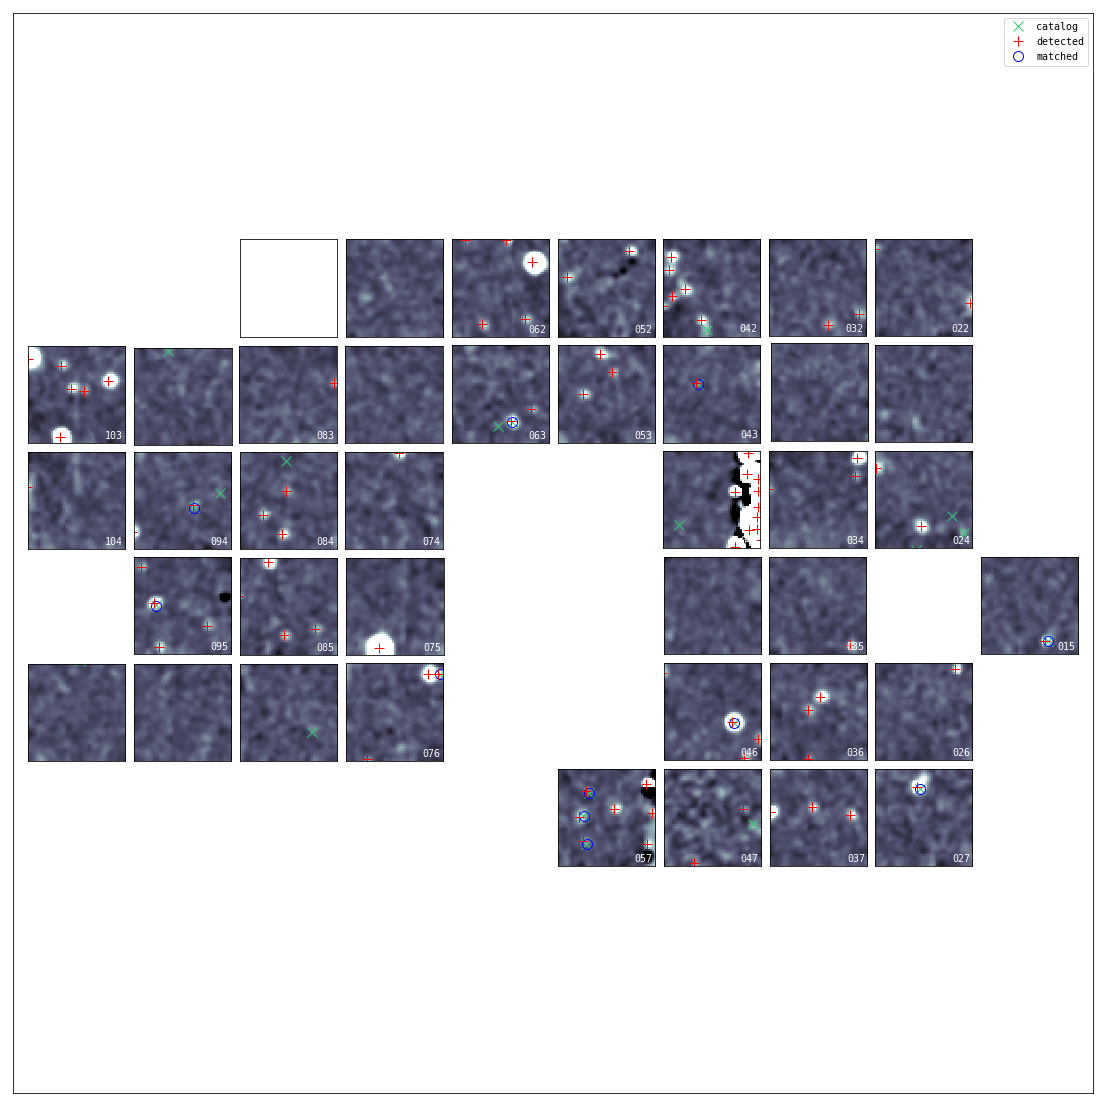

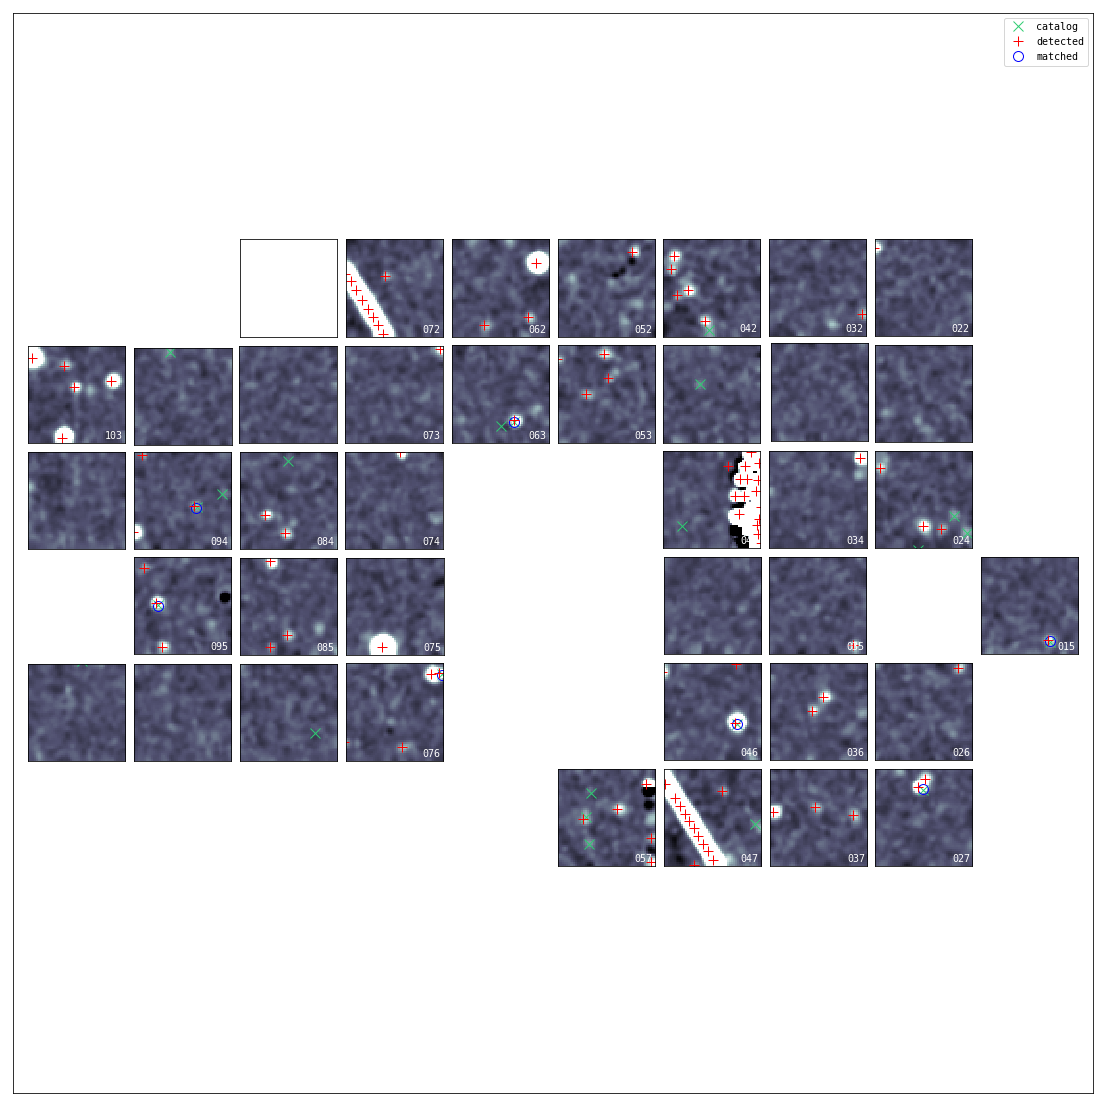

In [206]:
from astropy.io import ascii
from vdrp import utils
cmap = plt.cm.bone

# read las file to get actual detections
from vdrp.daophot import DAOPHOT_ALS
    


def mk_matrix(ax, exp, fplane_file, basedir):
    N = 1.
    
    tin = Table.read(os.path.join(basedir, shout_ifu_file), format='ascii')
    tout = Table( [tin['col2'], tin['col3'], tin['col4']], names=['id','ra','dec'])

    print("Loading image files")
    images = OrderedDict()
    headers = OrderedDict()
    with path.Path(basedir):
        for f in exposures_files[exp]:
            images[f] = fits.getdata(f + '.fits')
            headers[f] = fits.getheader(f + '.fits')
    
    # Here we translate *all* catalog stars to x/y to display then and to 
    ifu_xy = project_xy(basedir, radec_files[exp], fplane_file, tout['ra'], tout['dec'])
    
    # Read xy information, i.e. catalog derived x/y positions vs. actual detecion x/y
    t = ascii.read( os.path.join(basedir,xy_files[exp]) )
    matched = Table( [t['IFUSLOT_cat'], t['xifu_cat'], t['yifu_cat']], names=['ifuslot', 'xifu', 'yifu'])


    RMAX = 510.

    # Matrix
    ax_all = plt.axes([0.,0.,1/N,1/N])
    
    # next lines only to get a legend
    ax_all.plot([],[],'x',label="catalog",c='#2ECC71',markersize=10)
    ax_all.plot([],[],'r+',label="detected",markersize=10)
    ax_all.plot([],[],'o',label="matched",markersize=10, markerfacecolor='none', markeredgecolor='b')
    l = ax_all.legend()
            

    ax_all.xaxis.set_visible(False)
    ax_all.yaxis.set_visible(False)

    scaling = 1.8
    s = 51. * scaling

    fp = fplane.FPlane( os.path.join(basedir, fplane_file) )
    for f in images:
        ifuslot = f[-3:]

        if not ifuslot in fp.ifuslots:
            continue
        ifu = fp.by_ifuslot(ifuslot)
        x,y,xw,xy = (-(ifu.x) + RMAX - s/2)/N, (ifu.y - s/2 + RMAX)/N, s/N, s/N

        ax = plt.axes([x/RMAX/2.,y/RMAX/2.,xw/RMAX/2.,xy/RMAX/2.])

        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        try:
            h = headers[f]
            xsize   = h['NAXIS1']
            ysize   = h['NAXIS2']
            xcenter = h['CRVAL1']
            ycenter = h['CRVAL2']
            extent = [0.+xcenter,xsize+xcenter,0.+ycenter,ysize+ycenter]

            ax.imshow( np.rot90(images[f], k=3), extent=extent, origin='bottom', vmin=-5., vmax=10., cmap=cmap)

            ii = ifu_xy['ifuslot'] == int(ifuslot)
            jj = matched['ifuslot'] == int(ifuslot)

            # don't get confused about rotations
            ax.plot(- ifu_xy['yifu'][ii], ifu_xy['xifu'][ii], 'x',c='#2ECC71',markersize=10)
            ax.plot(- matched['yifu'][jj], matched['xifu'][jj], 'o',markersize=10, markerfacecolor='none', markeredgecolor='b')

            ax.set_xlim([extent[0],extent[1]])
            ax.set_ylim([extent[2],extent[3]])
        
            dp = DAOPHOT_ALS.read( os.path.join(basedir, f + '.als') )
            ax.plot(- dp.data['Y']+51./2., dp.data['X']-51./2., 'r+',markersize=10)
            ax.text(.975,.025,ifuslot,transform=ax.transAxes,color='white',ha='right',va='bottom')
        except:
            pass

for exp in exposures:
    f = plt.figure(figsize=[15,15])
    ax = plt.subplot(111)
    mk_matrix(ax, exp, fplane_file, basedir)
    f.savefig("detect_{}.pdf".format(exp))

In [158]:
dd = np.loadtxt(os.path.join(basedir,"getoff_-0.100Deg.out"))

In [160]:
dra =  (dd[:,2] - dd[:,4]) 
ddec =  (dd[:,3] - dd[:,5]) 

In [153]:
np.sqrt( (dra/np.cos( np.deg2rad(ddec) ) )**2. + ddec**2.) * 3600.

0.465235034739747

In [165]:
"{:.3f}".format( np.std( dra*np.cos( np.deg2rad(ddec) ) )* 3600. )

'1.937'

In [157]:
dra

-0.0001271428571426116

In [33]:
import glob
import scipy

In [34]:
from scipy import interpolate

NameError: name 'ang_off_avg' is not defined

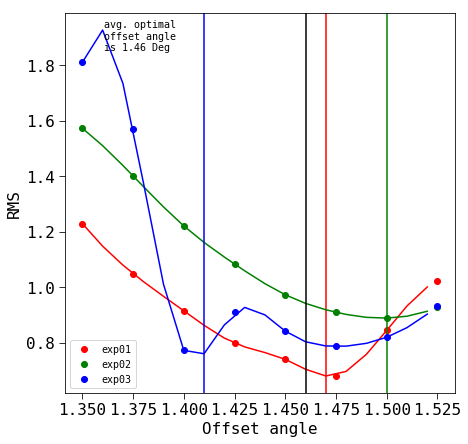

In [35]:



def mk_ang_off_plot(ax, basedir):
    colors = ['red','green','blue']
    exposures = ['exp01','exp02', 'exp03']
    
    # load getoff2 data for all exposures
    results = Table(names=['exposure','ang_off','RMS'], dtype=['S5',float, float])
    for exp in exposures:
        list = glob.glob("{}/getoff2_{}*Deg.out".format(basedir,exp))
        for filename in list:
            ang = float( filename.replace('Deg.out','').split("_")[-1] )
            with open(filename) as f:
                ll = f.readlines()
            try:
                tt = ll[0].split()
                rms_dra = float( tt[2] )
                rms_ddec = float( tt[3] )
                #print( ang, np.sqrt(rms_dra**2. + rms_ddec**2.) )
                results.add_row( [ exp, ang, np.sqrt(rms_dra**2. + rms_ddec**2.)]  )
            except:
                print("Error parsing {}".format(filename))

            
    # angular subgrid for interpolation
    aa = np.arange( results['ang_off'].min(), results['ang_off'].max() , 0.01)
    aamin = Table(names=["exposure", "ang_off_min", "RMS_min"], dtype=['S5',float, float])
    for i,exp in enumerate(exposures):
        ii = results['exposure'] == exp
        x = results['ang_off'][ii]
        y = results['RMS'][ii]
        plt.plot(x,y ,'o', c=colors[i], label=exp)


        f = interpolate.interp1d(x, y, kind='cubic', bounds_error=False)
        plt.plot(aa,f(aa) ,'-', c=colors[i])
        # find best offset angle
        imin = np.nanargmin(f(aa))
        amin = aa[imin]
        rms_min = f(aa[imin])
        plt.axvline(amin,color=colors[i])

        aamin.add_row([exp, amin, rms_min] )
        
    # average optimal offset angle accross all exposures
    ang_off_avg = np.nanmean( aamin['ang_off_min'] )

    plt.axvline(ang_off_avg,color="k")
    plt.legend()
    plt.xlabel("Offset angle")
    plt.ylabel("RMS")
    ang_off_avg = np.mean( aamin['ang_off_min'] )
    plt.text(.1,.9, "avg. optimal\noffset angle\nis {:.5} Deg".format( ang_off_avg), transform=ax.transAxes)

f = plt.figure(figsize = [7,7])
ax = plt.subplot(111)
mk_ang_off_plot(ax, basedir + "/add_radec_angoff_trial")

print( ang_off_avg )

In [180]:
from astropy.io import ascii
from vdrp import utils
import matplotlib.gridspec as gridspec
%matplotlib inline

cmap = plt.cm.bone

# read las file to get actual detections
from vdrp.daophot import DAOPHOT_ALS
    


def mk_matrix(ax_for_exp_slot, exp, fplane_file, basedir):
    N = 1.
    
    tin = Table.read(os.path.join(basedir, shout_ifu_file), format='ascii')
    tout = Table( [tin['col2'], tin['col3'], tin['col4']], names=['id','ra','dec'])

    print("Loading image files")
    images = OrderedDict()
    headers = OrderedDict()
    with path.Path(basedir):
        for f in exposures_files[exp]:
            images[f] = fits.getdata(f + '.fits')
            headers[f] = fits.getheader(f + '.fits')
    
    # Here we translate *all* catalog stars to x/y to display then and to 
    ifu_xy = project_xy(basedir, radec_files[exp], fplane_file, tout['ra'], tout['dec'])
    
    # Read xy information, i.e. catalog derived x/y positions vs. actual detecion x/y
    t = ascii.read( os.path.join(basedir,xy_files[exp]) )
    matched = Table( [t['IFUSLOT_cat'], t['xifu_cat'], t['yifu_cat']], names=['ifuslot', 'xifu', 'yifu'])


    RMAX = 510.

    # Matrix
    #fig = plt.figure(figsize=[15,15])
    #ax_all = plt.axes([0.,0.,1/N,1/N])
    
    # next lines only to get a legend
    #ax_all.plot([],[],'x',label="catalog",c='grey')
    #ax_all.plot([],[],'b.',label="matched")
    #ax_all.plot([],[],'r+',label="detected")
    #l = ax_all.legend()
            

    #ax_all.xaxis.set_visible(False)
    #ax_all.yaxis.set_visible(False)

    #scaling = 1.8
    #s = 51. * scaling

    fp = fplane.FPlane( os.path.join(basedir, fplane_file) )
    for f in images:
        ifuslot = f[-3:]

        if not ifuslot in fp.ifuslots:
            continue
        ifu = fp.by_ifuslot(ifuslot)
        
        ax = ax_for_exp_slot[ (exp, ifuslot) ]

        try:
            h = headers[f]
            xsize   = h['NAXIS1']
            ysize   = h['NAXIS2']
            xcenter = h['CRVAL1']
            ycenter = h['CRVAL2']
            extent = [0.+xcenter,xsize+xcenter,0.+ycenter,ysize+ycenter]

            ax.imshow( np.rot90(images[f], k=3), extent=extent, origin='bottom', vmin=-5., vmax=10., cmap=cmap)

            ii = ifu_xy['ifuslot'] == int(ifuslot)
            jj = matched['ifuslot'] == int(ifuslot)

            # don't get confused about rotations
            ax.plot(- ifu_xy['yifu'][ii], ifu_xy['xifu'][ii], 'x',c='grey')
            ax.plot(- matched['yifu'][jj], matched['xifu'][jj], 'b.')

            ax.set_xlim([extent[0],extent[1]])
            ax.set_ylim([extent[2],extent[3]])
        
            dp = DAOPHOT_ALS.read( os.path.join(basedir, f + '.als') )
            ax.plot(- dp.data['Y']+51./2., dp.data['X']-51./2., 'r+')
        except:
            pass

Loading image files
Loading image files
Loading image files


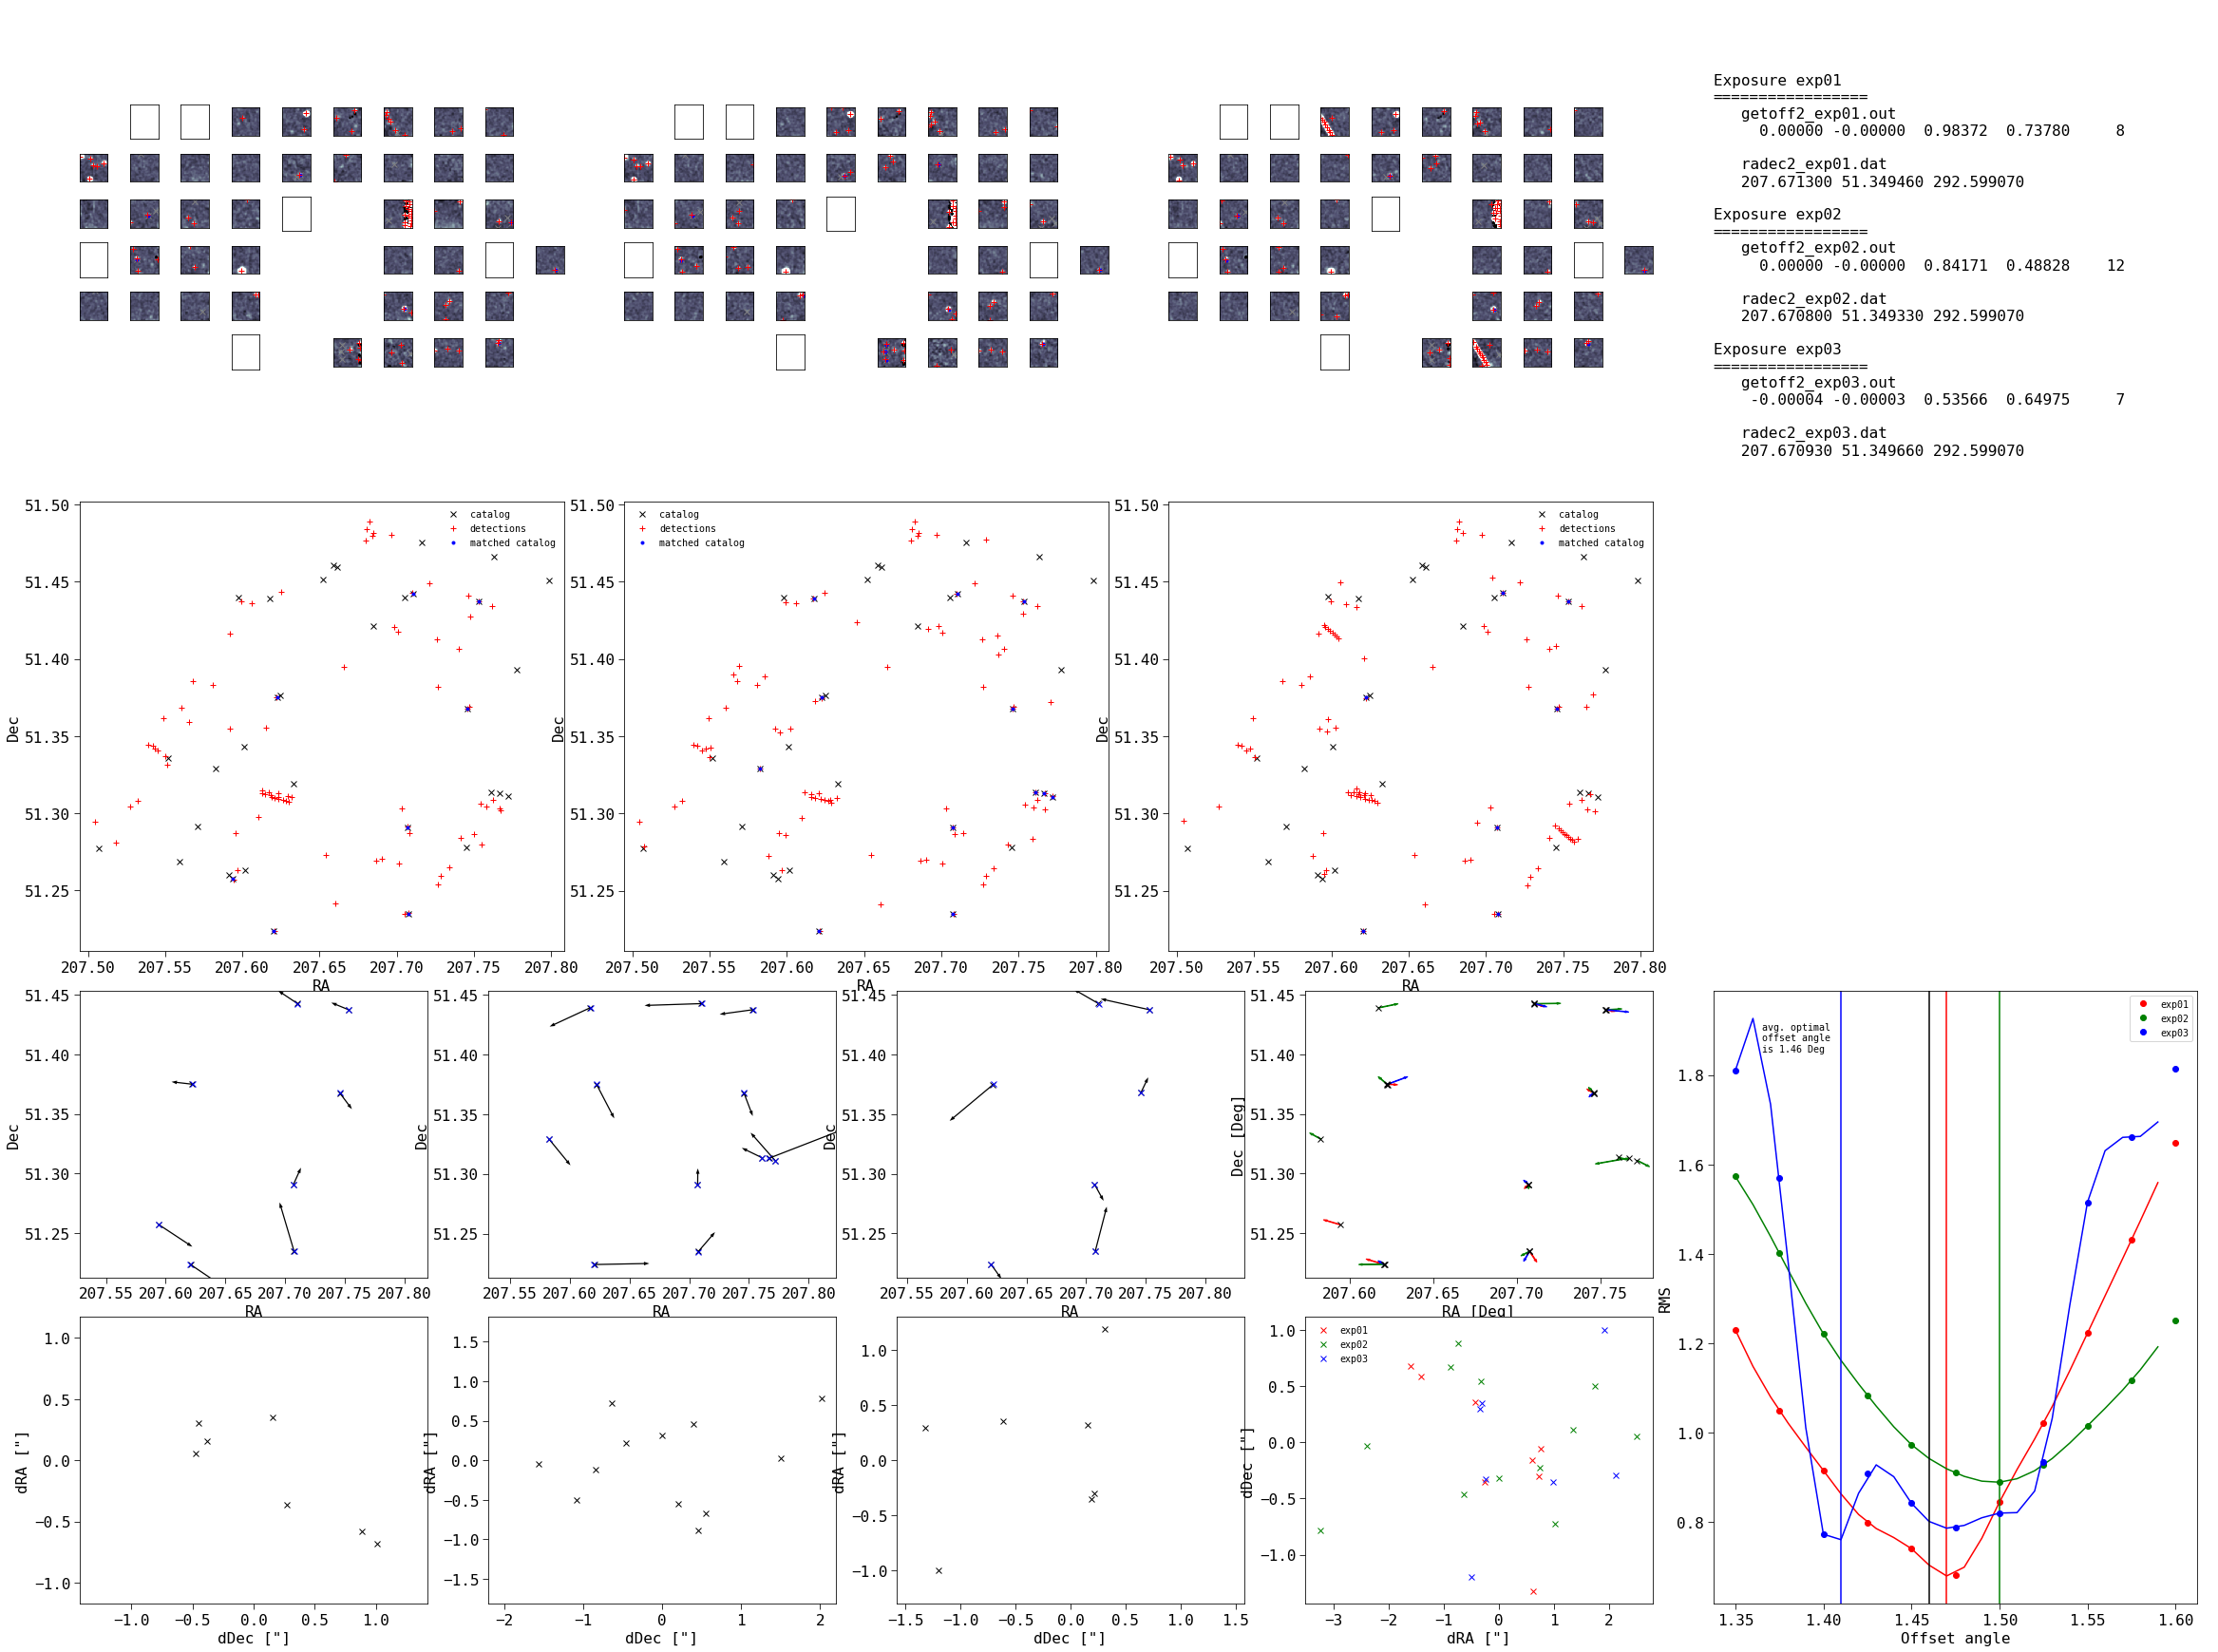

In [190]:
% matplotlib inline
fig = plt.figure(figsize = [32,24])

#rowcol = (10,16)

gs = gridspec.GridSpec(10, 16)

#for exp in ax_matrix: fig.add_axes(ax_matrix[exp])
ax_info = plt.Subplot(fig, gs[0:4, 12:18])
ax_info.axis('off')
fig.add_axes(ax_info)

ax_match = {}
ax_match['exp01'] = plt.Subplot(fig, gs[3:6, 0:4])
ax_match['exp02'] = plt.Subplot(fig, gs[3:6, 4:8])
ax_match['exp03'] = plt.Subplot(fig, gs[3:6, 8:12])
for exp in ax_match: fig.add_axes(ax_match[exp])

ax_dist = {}
ax_dist['exp01'] = plt.Subplot(fig, gs[6:8, 0:3])
ax_dist['exp02'] = plt.Subplot(fig, gs[6:8, 3:6])
ax_dist['exp03'] = plt.Subplot(fig, gs[6:8, 6:9])
ax_expall_dist   = plt.Subplot(fig, gs[6:8, 9:12])
for exp in ax_dist: fig.add_axes(ax_dist[exp])
fig.add_axes(ax_expall_dist)

ax_res = {}
ax_res['exp01']  = plt.Subplot(fig, gs[8:10, 0:3])
ax_res['exp02']  = plt.Subplot(fig, gs[8:10, 3:6])
ax_res['exp03']  = plt.Subplot(fig, gs[8:10, 6:9])
ax_expall_res    = plt.Subplot(fig, gs[8:10, 9:12])
for exp in ax_res: fig.add_axes(ax_res[exp])
fig.add_axes(ax_expall_res)

ax_angoff        = plt.Subplot(fig, gs[6:10, 12:16])
fig.add_axes(ax_angoff)

fig.tight_layout()

ax_matrix = {}
#ax_matrix['exp01'] = plt.Subplot(fig, gs[0:3, 0:4])
#ax_matrix['exp02'] = plt.Subplot(fig, gs[0:3, 4:8])
#ax_matrix['exp03'] = plt.Subplot(fig, gs[0:3, 8:12])

ax_matrix['exp01'] = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs[0:3, 0:4])
ax_matrix['exp02'] = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs[0:3, 4:8])
ax_matrix['exp03'] = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs[0:3, 8:12])


s = ""
for i, exp in enumerate( exposures ):
    s += "Exposure {}\n".format(exp)
    s += "=================\n"
    fn = "getoff2_{}.out".format(exp)
    s += "   " + fn + "\n"
    with open(os.path.join(basedir,fn)) as f:
        ll = f.readlines()
    for l in ll:
        s += "   " + l + "\n"
        
    fn = "radec2_{}.dat".format(exp)
    s += "   " + fn + "\n"
    with open(os.path.join(basedir,fn)) as f:
        ll = f.readlines()
    for l in ll:
        s += "   " + l + "\n"    
        
ax_info.text(0.0,.9,s,transform=ax_info.transAxes, va='top', ha='left', size=16)

shout_ifu = Table.read(os.path.join(basedir, shout_ifu_file), format='ascii')


for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    tmp_csv = Table.read( os.path.join(basedir,tmp_csv_files[exp]) )
    mk_match_plot(ax_match[exp], shout_ifu, tmp_csv, xy)

for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    mk_dist_plot(ax_dist[exp], xy)
    
for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    
    mk_res_plot(ax_res[exp], xy)
    
mk_dist_all_plot(ax_expall_dist, basedir, xy_files)
#ax_expall_dist.plot([1,2,3],[1,2,3],'o')
mk_res_all_plot(ax_expall_res, basedir, xy_files) 
    
mk_ang_off_plot(ax_angoff, basedir + "/add_radec_angoff_trial")





fp = fplane.FPlane(os.path.join(basedir,fplane_file))




ax_for_exp_slot = {}
for exp in exposures:
    
    for ifu in fp.ifus:
        col,row = int(np.round(-ifu.x/100.+4.5)),int(np.round(-ifu.y/100.+4.5))
        ifu_ax = plt.Subplot(fig, ax_matrix[exp][row, col]) 
        fig.add_subplot(ifu_ax)
        ifu_ax.xaxis.set_visible(False)
        ifu_ax.yaxis.set_visible(False)
        ax_for_exp_slot[(exp,ifu.ifuslot)] = ifu_ax
        
        
for exp in exposures:
    #f = plt.figure(figsize=[7,7])
    #ax = plt.subplot(111)
    mk_matrix(ax_for_exp_slot, exp, fplane_file, basedir)

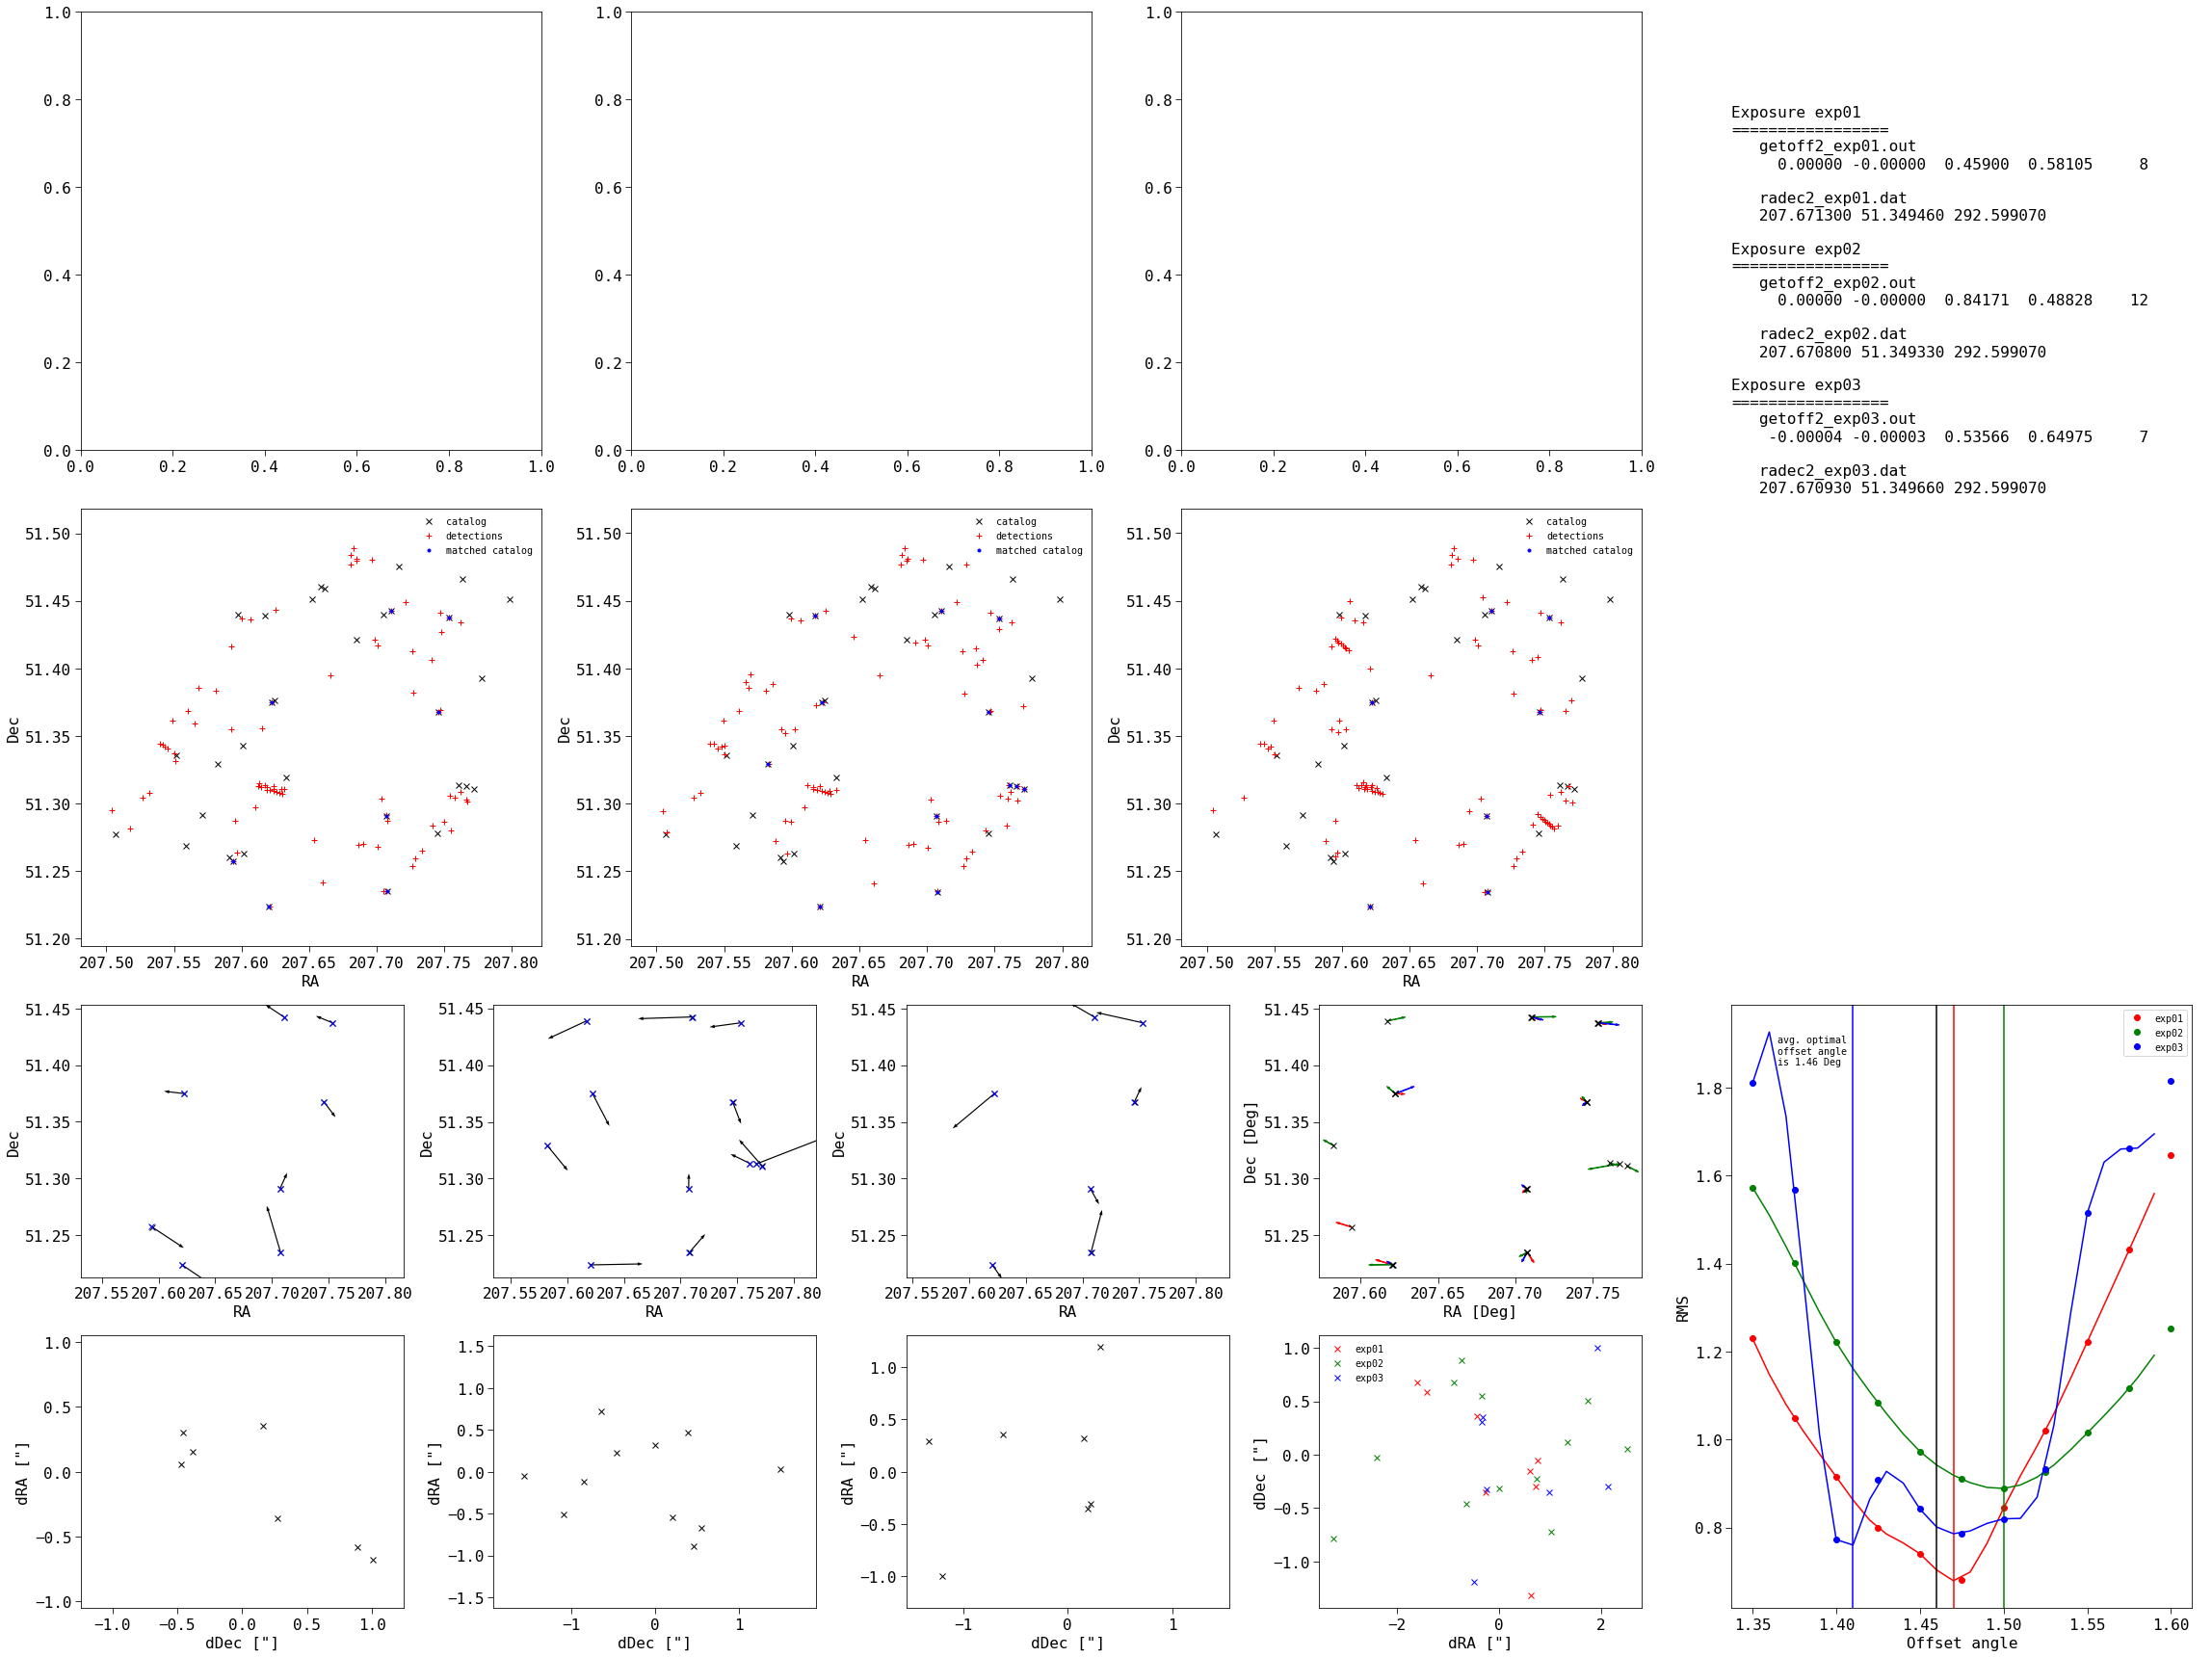

In [69]:
fig = plt.figure(figsize = [32,24])

#rowcol = (10,16)

gs = gridspec.GridSpec(10, 16)

ax_matrix = {}
ax_matrix['exp01'] = plt.subplot2grid(rowcol, (0, 0), colspan=4, rowspan=3)
ax_matrix['exp02'] = plt.subplot2grid(rowcol, (0, 4), colspan=4, rowspan=3)
ax_matrix['exp03'] = plt.subplot2grid(rowcol, (0, 8), colspan=4, rowspan=3)

ax_info = plt.subplot2grid(rowcol, (0, 12), colspan=4, rowspan=6)
ax_info.axis('off')

ax_match = {}
ax_match['exp01'] = plt.subplot2grid(rowcol, (3, 0), colspan=4, rowspan=3)
ax_match['exp02'] = plt.subplot2grid(rowcol, (3, 4), colspan=4, rowspan=3)
ax_match['exp03']= plt.subplot2grid(rowcol, (3, 8), colspan=4, rowspan=3)

ax_dist = {}
ax_dist['exp01'] = plt.subplot2grid(rowcol, (6, 0), colspan=3, rowspan=2)
ax_dist['exp02'] = plt.subplot2grid(rowcol, (6, 3), colspan=3, rowspan=2)
ax_dist['exp03'] = plt.subplot2grid(rowcol, (6, 6), colspan=3, rowspan=2)
ax_expall_dist = plt.subplot2grid(rowcol, (6, 9), colspan=3, rowspan=2)

ax_res = {}
ax_res['exp01']  = plt.subplot2grid(rowcol, (8, 0), colspan=3, rowspan=2)
ax_res['exp02']  = plt.subplot2grid(rowcol, (8, 3), colspan=3, rowspan=2)
ax_res['exp03']  = plt.subplot2grid(rowcol, (8, 6), colspan=3, rowspan=2)
ax_expall_res = plt.subplot2grid(rowcol, (8, 9), colspan=3, rowspan=2)

ax_angoff = plt.subplot2grid(rowcol, (6, 12), colspan=4, rowspan=4)


s = ""
for i, exp in enumerate( exposures ):
    s += "Exposure {}\n".format(exp)
    s += "=================\n"
    fn = "getoff2_{}.out".format(exp)
    s += "   " + fn + "\n"
    with open(os.path.join(basedir,fn)) as f:
        ll = f.readlines()
    for l in ll:
        s += "   " + l + "\n"
        
    fn = "radec2_{}.dat".format(exp)
    s += "   " + fn + "\n"
    with open(os.path.join(basedir,fn)) as f:
        ll = f.readlines()
    for l in ll:
        s += "   " + l + "\n"    
        
ax_info.text(0.0,.9,s,transform=ax_info.transAxes, va='top', ha='left', size=16)

shout_ifu = Table.read(os.path.join(basedir, shout_ifu_file), format='ascii')


for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    tmp_csv = Table.read( os.path.join(basedir,tmp_csv_files[exp]) )
    mk_match_plot(ax_match[exp], shout_ifu, tmp_csv, xy)

for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    mk_dist_plot(ax_dist[exp], xy)
    
for i, exp in enumerate( exposures ):
    xy = ascii.read(os.path.join(basedir,xy_files[exp]))
    
    mk_res_plot(ax_res[exp], xy)
    
mk_dist_all_plot(ax_expall_dist, basedir, xy_files)
#ax_expall_dist.plot([1,2,3],[1,2,3],'o')
mk_res_all_plot(ax_expall_res, basedir, xy_files) 
    
mk_ang_off_plot(ax_angoff, basedir + "/add_radec_angoff_trial")

fig.tight_layout()







Loading image files
Loading image files
Loading image files


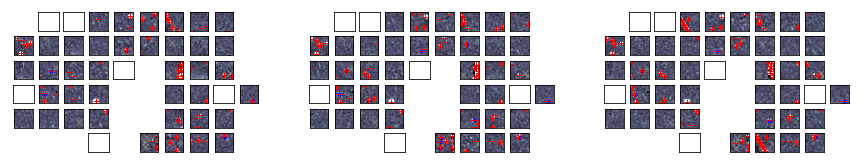

In [159]:
from astropy.io import ascii
from vdrp import utils
import matplotlib.gridspec as gridspec
%matplotlib inline

cmap = plt.cm.bone

# read las file to get actual detections
from vdrp.daophot import DAOPHOT_ALS
    


def mk_matrix(ax_for_exp_slot, exp, fplane_file, basedir):
    N = 1.
    
    tin = Table.read(os.path.join(basedir, shout_ifu_file), format='ascii')
    tout = Table( [tin['col2'], tin['col3'], tin['col4']], names=['id','ra','dec'])

    print("Loading image files")
    images = OrderedDict()
    headers = OrderedDict()
    with path.Path(basedir):
        for f in exposures_files[exp]:
            images[f] = fits.getdata(f + '.fits')
            headers[f] = fits.getheader(f + '.fits')
    
    # Here we translate *all* catalog stars to x/y to display then and to 
    ifu_xy = project_xy(basedir, radec_files[exp], fplane_file, tout['ra'], tout['dec'])
    
    # Read xy information, i.e. catalog derived x/y positions vs. actual detecion x/y
    t = ascii.read( os.path.join(basedir,xy_files[exp]) )
    matched = Table( [t['IFUSLOT_cat'], t['xifu_cat'], t['yifu_cat']], names=['ifuslot', 'xifu', 'yifu'])


    RMAX = 510.

    # Matrix
    #fig = plt.figure(figsize=[15,15])
    #ax_all = plt.axes([0.,0.,1/N,1/N])
    
    # next lines only to get a legend
    #ax_all.plot([],[],'x',label="catalog",c='grey')
    #ax_all.plot([],[],'b.',label="matched")
    #ax_all.plot([],[],'r+',label="detected")
    #l = ax_all.legend()
            

    #ax_all.xaxis.set_visible(False)
    #ax_all.yaxis.set_visible(False)

    #scaling = 1.8
    #s = 51. * scaling

    fp = fplane.FPlane( os.path.join(basedir, fplane_file) )
    for f in images:
        ifuslot = f[-3:]

        if not ifuslot in fp.ifuslots:
            continue
        ifu = fp.by_ifuslot(ifuslot)
        
        ax = ax_for_exp_slot[ (exp, ifuslot) ]

        try:
            h = headers[f]
            xsize   = h['NAXIS1']
            ysize   = h['NAXIS2']
            xcenter = h['CRVAL1']
            ycenter = h['CRVAL2']
            extent = [0.+xcenter,xsize+xcenter,0.+ycenter,ysize+ycenter]

            ax.imshow( np.rot90(images[f], k=3), extent=extent, origin='bottom', vmin=-5., vmax=10., cmap=cmap)

            ii = ifu_xy['ifuslot'] == int(ifuslot)
            jj = matched['ifuslot'] == int(ifuslot)

            # don't get confused about rotations
            ax.plot(- ifu_xy['yifu'][ii], ifu_xy['xifu'][ii], 'x',c='grey')
            ax.plot(- matched['yifu'][jj], matched['xifu'][jj], 'b.')

            ax.set_xlim([extent[0],extent[1]])
            ax.set_ylim([extent[2],extent[3]])
        
            dp = DAOPHOT_ALS.read( os.path.join(basedir, f + '.als') )
            ax.plot(- dp.data['Y']+51./2., dp.data['X']-51./2., 'r+')
        except:
            pass

        
        
f = plt.figure(figsize=[15,10])
gs = gridspec.GridSpec(2, 3)
#ax = plt.subplot(gs[0, 0])

ax1 = plt.Subplot(f, gs[0, 1])
ax2 = plt.Subplot(f, gs[1, 0])
ax3 = plt.Subplot(f, gs[1, 1])

fp = fplane.FPlane(os.path.join(basedir,fplane_file))


gs_exp = {}

gs_exp['exp01'] = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs[0,0])
gs_exp['exp02'] = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs[0,1])
gs_exp['exp03'] = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs[0,2])


ax_for_exp_slot = {}
for exp in exposures:
    
    for ifu in fp.ifus:
        col,row = int(np.round(-ifu.x/100.+4.5)),int(np.round(-ifu.y/100.+4.5))
        ifu_ax = plt.Subplot(f, gs_exp[exp][row, col]) 
        f.add_subplot(ifu_ax)
        ifu_ax.xaxis.set_visible(False)
        ifu_ax.yaxis.set_visible(False)
        ax_for_exp_slot[(exp,ifu.ifuslot)] = ifu_ax
        
        
for exp in exposures:
    #f = plt.figure(figsize=[7,7])
    #ax = plt.subplot(111)
    mk_matrix(ax_for_exp_slot, exp, fplane_file, basedir)

In [155]:
ax = ax_for_exp_slot[('exp01', '000')]

In [156]:
ax = ax_for_exp_slot[(exp, ifuslot)]

NameError: name 'ifuslot' is not defined